#### Sensitivity Analysis

We want to assess the impact of each parameter on the output of the model. Thereby, we want to identify the most influential factors and quantify their effects. Either local or global sensitivity analysis can be conducted. Within the local sensitivity analysis, one variable at a time is changed while the global sensitivity analysis considers multiple variables simultaneously.

#### Overview

* Load the parameters
* Define their perturbation (30%)
* Save parameter name, values and lower and upper bounds in variable 'problem'
* Create a chosen number of sample sets of the parameters applying **saltelli**
* Calculate the RMSE of the model output for each parameter set
* **Sobol Analysis** based on problem and sample sets
* Plot impact of each parameter in bar plot

#### Code

In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from D_model_sens import objective_function, model_sensitivity_analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [20]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

In [21]:
mu_max = param['mu_max']
X_max = param['X_max']
Ks = param['Ks']
Ks_qs = param['Ks_qs']
Ki = param['Ki']
Yxs = param['Yxs']
qs_max = param['qs_max']
m_s = param['m_s']
lag = param['lag']

In [22]:
# Perturbation range
perc = 0.5

lb_mu_max, ub_mu_max = mu_max - (mu_max*perc), mu_max + (mu_max*perc)
lb_X_max, ub_X_max = X_max - (X_max*perc), X_max + (X_max*perc)
lb_Yxs, ub_Yxs = Yxs - (Yxs*perc), Yxs + (Yxs*perc)
lb_m_s, ub_m_s = m_s - (m_s*perc), m_s + (m_s*perc)

In [23]:
# Define the number of parameters and the parameter ranges
problem = {'num_vars' : 3,
           'names' : ['mu_max', 'X_max', 'Yxs'],
           'bounds' : [[lb_mu_max, ub_mu_max], 
                       [lb_X_max, ub_X_max], 
                       [lb_Yxs, ub_Yxs]]
}

# number of sample sets (output will be N * (D + 2) where N is n_samples and D is the number of parameters)
n_samples = 64
param_values = saltelli.sample(problem, n_samples, calc_second_order=False)

print(param_values.shape)
param_values[0]

(320, 3)


C:\Users\dxp2904\AppData\Local\Temp\ipykernel_2968\3555055950.py:11: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, n_samples, calc_second_order=False)


array([ 0.1046875, 20.8078125,  0.63375  ])

Optional: **Normalization**
* would make sense to minimize the effect of different scales (if not higher values will have higher impact)
* output of the model would not make sense?

In [24]:
'''means = np.mean(param_values, axis=0)
std_devs = np.std(param_values, axis=0)
normalized_parameters = (param_values - means) / std_devs
normalized_parameters.shape

mins = np.min(param_values, axis=0)
maxs = np.max(param_values, axis=0)
normalized_parameters = (param_values - mins) / (maxs - mins)
normalized_parameters.shape'''

'means = np.mean(param_values, axis=0)\nstd_devs = np.std(param_values, axis=0)\nnormalized_parameters = (param_values - means) / std_devs\nnormalized_parameters.shape\n\nmins = np.min(param_values, axis=0)\nmaxs = np.max(param_values, axis=0)\nnormalized_parameters = (param_values - mins) / (maxs - mins)\nnormalized_parameters.shape'

In [7]:
# Evaluate the model for each set of parameter samples
model_outputs = np.zeros(param_values.shape[0])
for n in range(param_values.shape[0]):
    # Define your fermentation model function here
    rmse = objective_function(param_values[n])
    ## biomass_pred, substrate_pred = model_sensitivity_analysis(param_values[n])
    model_outputs[n] = rmse

# Perform Sobol' analysis
sobol_indices = sobol.analyze(problem, model_outputs, print_to_console=False)

# Get the first-order indices and parameter names
first_order_indices = sobol_indices['S1']
first_order_indices

array([-0.0274643 , -0.1417772 ,  0.05691107])

<BarContainer object of 3 artists>

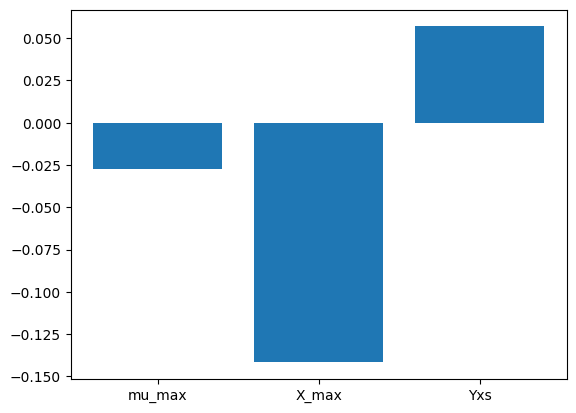

In [8]:
plt.bar(problem['names'], first_order_indices)

Overall, negative sensitivity indices in Sobol analysis indicate that the model output is primarily driven by parameter interactions rather than individual parameter effects. Understanding these interactions is crucial for accurately representing and predicting the system's behavior.

In [27]:
sorted_indices = np.argsort(first_order_indices)[::-1]
sorted_indices

array([2, 0, 1])